In [1]:
import rasterio
import geopandas as gpd
from dotenv import load_dotenv
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.features import geometry_mask
import scipy
import pandas as pd


load_dotenv()
directory = os.getenv("path")

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.resetwarnings()


internal_proj_uom_get_info_from_database: Cannot find proj.db


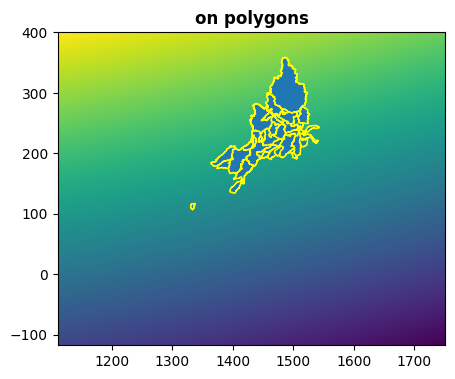

In [3]:
# read the rasterio dataset
rf_path = os.path.join(directory, "ClimateIndices", "georeference", "tmax_2010_raster", "tmax_2010_raster.tif")
rf = rasterio.open(rf_path)

# read the shapefile
shp_path = os.path.join(directory, "ClimateIndices", "georeference", "on_subbasins", "new_ON_subbasins.shp")
shp = gpd.read_file(shp_path)

fig, ax = plt.subplots(1,1, figsize=(5,5))
show(rf, ax=ax, title='on polygons')
shp.plot(ax=ax, facecolor = None, edgecolor='yellow')

plt.show()

Working solution

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


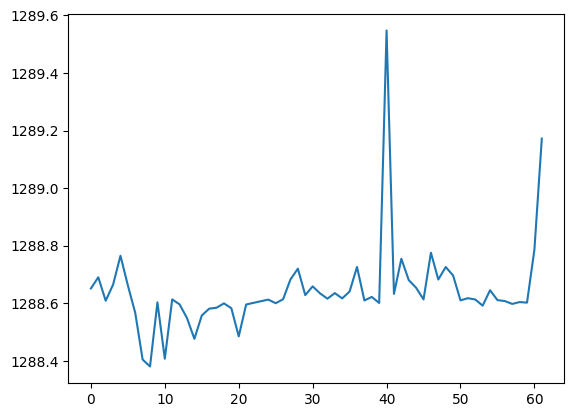

In [3]:
ds_path = os.path.join(directory, "ClimateIndices", "georeference", "2129_daymet_v4_daily_na_prcp_2011.nc")
shp_path = os.path.join(directory, "ClimateIndices", "georeference", "on_subbasins", "new_ON_subbasins.shp")

gdf = gpd.read_file(shp_path)

ds = xr.open_dataset(ds_path)
ds['prcp_calc']=ds['prcp'].sum(dim='time')

polygons = gdf.geometry

transform =ds.rio.transform()
zonal_stats = []
warnings.simplefilter("ignore", category=UserWarning)

# loop through the shapefiles and the zonal statistics
for geom in polygons:
    mask = geometry_mask([geom], out_shape=ds['prcp_calc'].shape, transform=transform)
    masked_data = np.ma.masked_array(ds['prcp_calc'].values, mask=~mask)
    mean_value = np.mean(masked_data)
    zonal_stats.append(mean_value)

gdf['mean_value'] = zonal_stats
warnings.resetwarnings()

gdf['mean_value'].plot()
plt.show()

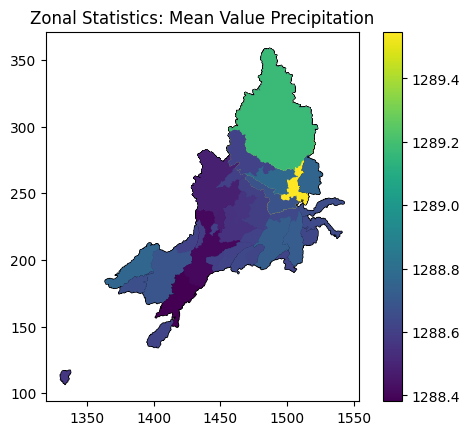

In [10]:
ax = gdf.plot(edgecolor='black', facecolor='none')

gdf.plot(ax=ax, column='mean_value', cmap='viridis', legend=True)

plt.title('Zonal Statistics: Mean Value Precipitation')
plt.show()

In [5]:

def zonal_climate(matrix_path):
    """
    This function takes in a dataset and computes the zonal statistics for each polygon in the shapefile
    :param year_dataset: dataset
    :return: a dataframe with the zonal statistics
    """

    # __init__ netcdf file to store the climate indices
    ds_path = os.path.join(directory, "ClimateIndices", "georeference", "2129_daymet_v4_daily_na_prcp_2011.nc")
    ds = xr.open_dataset(ds_path)

    # read the shapefile
    shp_path = os.path.join(directory, "ClimateIndices", "georeference", "on_subbasins", "new_ON_subbasins.shp")
    gdf = gpd.read_file(shp_path)
    polygons = gdf.geometry

    # climate indices data initially stored in a matlab files
    mat_data = scipy.io.loadmat(matrix_path)
    climate_indices = [key for key in mat_data.keys() if '__' not in key]
    print(f"The length of the climate indices is {len(climate_indices)}")

    zonal_climate_indices = []
    for index in climate_indices:
        mat_shape = mat_data[index].shape
        if mat_shape[0] == 630:
            ds[index] = (('y', 'x'), mat_data[index].T)
        else:
            ds[index] = (('y', 'x'), mat_data[index].T)

        polygons = gdf.geometry
        transform = ds.rio.transform()

        # 2D for storing zonal stat. indexof -- 0: mean, 1:median, 2:std
        zonal_stats = [[] for _ in range(3)]
        zonal_stats_dict = {}
        for geom in polygons:
            mask = geometry_mask([geom], out_shape=ds[index].shape, transform=transform)
            masked_data = np.ma.masked_array(ds[index].values, mask=~mask)
            zonal_stats[0].append(np.ma.mean(masked_data))
            zonal_stats[1].append( np.ma.median(masked_data))
            zonal_stats[2].append(np.ma.std(masked_data))
            zonal_stats_dict[index.split("_mapcurrentyear")[0]] = zonal_stats
        # gdf[f'mean_{index.split("_mapcurrentyear")[0]}'] = zonal_stats[0]
        zonal_climate_indices.append(zonal_stats_dict)

    return zonal_climate_indices

# -- test
matrix_path = os.path.join(directory, "ClimateIndices", "ClimateIndices_Year2011_GeneratedNov2023.mat")
zonal_climate_indices = zonal_climate(matrix_path)
# gdf['mean_value'].plot()
# plt.show()

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


The length of the climate indices is 7


Generating a zonal statistic dataframe per year

In [23]:
def generate_zonal_stats(matrix_path, output_path):

    """
    This function takes the path of the matrix and the output_path. Computes zonal stats and saves
    a CSV that contains all zonal stats (mean, median, std) for a particular year.
    """

    zonal_climate_indices = zonal_climate(matrix_path)
    stations = shp.Station

    year_zonal_stats = []
    for indice in zonal_climate_indices:
        name = str(list(indice.keys())).strip("'[']")
        data = list(indice.values())
        transposed_data = np.transpose(data[0])
        columns = [f'mean_{name}_2011', f'median_{name}_2011', f'std_{name}_2011']
        zonal_df = pd.DataFrame(transposed_data, columns=columns)
        # zonal_df = pd.concat([stations, zonal_df], axis=1)
        year_zonal_stats.append(zonal_df)
        # zonal_df.to_csv(os.path.join(output_path, f'zonal_stats_{name}_2011.csv'))

    all_indicies = year_zonal_stats[0]
    for i in range(1, len(year_zonal_stats)):
        all_indicies= pd.concat([all_indicies, year_zonal_stats[i]], axis=1)

    all_indicies = pd.concat([stations, all_indicies], axis=1)
    all_indicies.to_csv(os.path.join(output_path, f'zonal_stats_2011.csv'))


# -- test:
output_path = os.path.join(directory, "ClimateIndices", "zonal_stats")
matrix_path = os.path.join(directory, "ClimateIndices", "ClimateIndices_Year2011_GeneratedNov2023.mat")

generate_zonal_stats(matrix_path, output_path)